# INTRODUCTION

## Business Case
To be able to achieve a fully electric future and keep up with the demand for chargers, the charging infrastructure has to be expanded. This is a great business opportunity for EV charging companies. By investing in Washington state, not only would these companies be eligible for government funding, but they would also put themselves in a profitable position as the demand for chargers continues to increase over the coming years. 

## Business Problem & Goal
In order to position electric vehicle chargers strategically, it is vital to model and predict the demand for electric vehicles in each county in Washington. In an effort to find counties that will have the most demand with the least amount of chargers, this analysis focuses on time series modeling of the amount of electric vehicles in the top 10 counties within Washington with the most purchases of new electric vehicles. Our goal is to recommend top 4 counties to invest in.

## Obtaining data from Washington State

### Importing data

In [1]:
import time
import pandas as pd
df=pd.read_csv('./dataset/Electric_Vehicle_Title_and_Registration_Activity.csv.gz',compression='gzip', index_col=0)
# df.info()

### Changing type of 'transaction_date' to datetime

#### Since we will be using the transaction_date column for the time series we are going to be creating, we need to change its type from object to datetime.

In [2]:
# df.head()

In [3]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
# df.head()

In [4]:
df['m/y'] = df['transaction_date'].dt.strftime("%m-%Y")

In [5]:
df.set_index('transaction_date', inplace=True)
# df.head()

## Column Exploration

There is great information in this dataframe but there seems to also be irrelevant information for our purposes. In order to clean up the dataframe we need to know which columns we should keep and which ones we should drop. 

We can go ahead and drop these columns since these are mostly about whether a fee was paid or if the vehicle met certain governmental requirements for tax credits or otherwise.

In [6]:
drop_cols = ['electric_vehicle_fee_paid',
             'hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility',
             'meets_2019_hb_2042_electric_range_requirement', 
             'meets_2019_hb_2042_sale_date_requirement', 
             'meets_2019_hb_2042_sale_price_value_requirement', 
             'transportation_electrification_fee_paid', 
             'hybrid_vehicle_electrification_fee_paid', 'legislative_district', 
             'non_clean_alternative_fuel','Unnamed: 31']
df.drop(drop_cols, axis=1, inplace=True)
# df.head()

### Dropping columns with redundant information

In [7]:
df['date_of_vehicle_sale'].isna().sum()

422951

Since we have the full transaction date in our index the 'transaction_year' column is redundant. Additionally, the date_of_vehicle_sale column seems to be missing quite a bit of information. Where there is data, the difference between the transaction date and the actual vehicle sale seems to be around a couple weeks so the difference is not meaningful for our purposes.

Also, we already have the sale price of the vehicle at the time of the transaction so the base MSRP column is irrelevant. So we can go ahead and drop these columns from our dataframe as well. We will be keeping the rest of the columns for the time being for EDA purposes.

In [8]:
drop_cols = ['transaction_year', 'base_msrp', 'date_of_vehicle_sale']
df.drop(drop_cols, axis=1, inplace=True)
# df.head()

We will not be using the registration information for this analysis and instead will be focusing on the title transactions to calculate the amount of electric vehicles on the road. Therefore we can filter out this information from our dataframe.

In [9]:
#filtering out registration information to keep vehicle purchase information
df=df[(df['transaction_type']=='Original Title') | 
      (df['transaction_type']=='Transfer Title')]
# df.info()

## Addressing Duplicates

Now that we have a dataframe that shows only the purchases of new and used cars and none of the registration information, we can go ahead and address duplicates.

### Exact Duplicates

In [10]:
df[df.duplicated()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


> We have 1287 rows of data that are duplicated. In order to make sure that these are indeed duplicates with no differences we will inspect a few of the vehicles below:

#### Inspecting Duplicates

In [11]:
df[df['dol_vehicle_id']==165661520]
df[df['dol_vehicle_id']==154225991]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017


Data in each column for these transactions seem to be exactly the same so we can go ahead and drop these rows.

In [12]:
df.drop_duplicates(inplace=True)
#verifying that duplicates have been removed
len(df[df.duplicated()])

0

In [13]:
df[df['dol_vehicle_id']==154225991]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017


### Duplicates by Date/ID/County


In [14]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id', 'county'], keep=False)].sort_values('dol_vehicle_id')

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2021-12-08,Plug-in Hybrid Electric Vehicle (PHEV),1G1RF6E42D,2013,CHEVROLET,Volt,Used,0,Transfer Title,Spokane,AIRWAY HEIGHTS,99001.0,38,Passenger,WA,2661907,111736,Actual Mileage,12-2021
2021-12-29,Plug-in Hybrid Electric Vehicle (PHEV),1G1RF6E42D,2013,CHEVROLET,Volt,Used,9995,Transfer Title,Spokane,SPOKANE,99208.0,38,Passenger,WA,2661907,112191,Actual Mileage,12-2021
2019-12-21,Battery Electric Vehicle (BEV),5YJ3E1EA0K,2019,TESLA,Model 3,Used,43200,Transfer Title,Snohomish,EVERETT,98204.0,220,Passenger,WA,2679813,246,Actual Mileage,12-2019
2019-12-05,Battery Electric Vehicle (BEV),5YJ3E1EA0K,2019,TESLA,Model 3,New,43200,Original Title,Snohomish,EVERETT,98204.0,220,Passenger,WA,2679813,0,No Odometer Code on File,12-2019
2021-04-26,Battery Electric Vehicle (BEV),5YJ3E1EA6L,2020,TESLA,Model 3,Used,0,Transfer Title,Yakima,UNION GAP,98903.0,266,Passenger,WA,2722485,14429,Actual Mileage,04-2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,Plug-in Hybrid Electric Vehicle (PHEV),2C4RC1N76J,2018,CHRYSLER,Pacifica,Used,13853,Transfer Title,King,KENT,98031.0,33,Passenger,WA,438868755,16811,Actual Mileage,07-2022
2021-03-26,Battery Electric Vehicle (BEV),1G1FZ6S00K,2019,CHEVROLET,Bolt EV,Used,25000,Transfer Title,King,SEATTLE,98118.0,238,Passenger,WA,474952670,4558,Actual Mileage,03-2021
2021-03-11,Battery Electric Vehicle (BEV),1G1FZ6S00K,2019,CHEVROLET,Bolt EV,Used,0,Transfer Title,King,SEATTLE,98144.0,238,Passenger,WA,474952670,4400,Actual Mileage,03-2021


The dataframe currently contains 98 rows of duplicated data. In this case, there are duplications for the same cars since there is different city and zipcode information shown in the transactions. Otherwise the data is exactly the same. We will be keeping the last of each of the duplicated rows.

In [15]:
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id', 'county'], keep='last', 
                   inplace=True)

In [16]:
# df.head()

In [17]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id'], 
                 keep=False)].sort_values('dol_vehicle_id')
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id'], keep='last', inplace=True)

Similar to the duplicates we removed in the prior section, we have duplicate transactions showing up for the same cars with exactly the same information except for the county, city and zipcode information. We will once again assume that the last transaction for each of these duplications is the accurate one, and keep it.

In [18]:
# df.drop_duplicates(subset=['m/y', 'dol_vehicle_id'], keep='last', inplace=True)

In [19]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id'], keep=False)].sort_values('dol_vehicle_id')

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


In [20]:
# df.info()

## Checking for and Addressing Null Values

In [21]:
df.isna().sum()
df[df['county'].isna()]
#dropping null values
df.dropna(subset=['county'], inplace=True)

The county information is missing on vehicles with owners residing in different states. Our analysis is focused on the Washington State and without in-state address information these data points are not going to be useful so we can go ahead and drop these from our dataframe.

In [22]:
#verifying that the null values have been dropped
df[df['county'].isna()]


,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


As discussed above, the data analysis is focused on Washington State, hence there is no reason to keep vehicles with owners residing outside of WA since we don't have their in-state locations. Additionally, this will remove all null values from the state_of_residence column.

In [23]:
df=df[df['state_of_residence']=='WA']

In [24]:
df[df['city'].isna()]
#filling null values
df['city'].fillna('Unknown', inplace=True)
#verifying that null values have been replaced
df[df['city'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


Since we are mainly concerned about the vehicles on a county level the null values in the city column are not concerning; however, we can change the null values with 'Unknown' as a placeholder.

In [25]:
df[df['zip'].isna()]
df['zip'].fillna('Unknown', inplace=True)

In [26]:
# df['zip'].fillna('Unknown', inplace=True)

In [27]:
#verifying that no null values are remaining
# df.isna().sum()

In [28]:
df['county'].value_counts()

King            86596
Snohomish       17817
Pierce          13009
Clark            9188
Kitsap           5694
Thurston         5680
Spokane          4061
Whatcom          4017
Benton           1899
Skagit           1719
Island           1697
Clallam           946
Jefferson         904
San Juan          851
Cowlitz           813
Yakima            776
Chelan            758
Mason             757
Lewis             615
Franklin          539
Grays Harbor      529
Grant             416
Walla Walla       392
Kittitas          386
Douglas           278
Whitman           232
Klickitat         230
Pacific           191
Stevens           189
Skamania          166
Okanogan          154
Asotin             69
Adams              53
Pend Oreille       45
Wahkiakum          40
Lincoln            33
Ferry              30
Columbia           17
Garfield            4
Name: county, dtype: int64

In [29]:
df['model'].unique()
#initial count of models
len(df['model'].unique())

127

In [30]:
df['model']=df['model'].map(lambda x: x.title())
df['model'].unique()

array(['Soul', 'E-Tron Sportback', 'Model S', 'Model 3', 'X5', 'E-Golf',
       'Bolt Ev', 'Volt', 'C-Max', 'Rav4 Prime', 'Model Y', 'Leaf', 'A3',
       '330E', '500', 'Soul Ev', 'Id.4', 'I3', 'Model X', 'I-Pace',
       'Roadster', 'Hardtop', 'Mustang Mach-E', 'Ps2', 'Wrangler', 'X3',
       'Pacifica', 'Focus', 'Prius Prime', 'Prius Plug-In', 'Niro',
       'Kona', 'Q5 E', 'Xc40', 'Ev6', 'Eqs-Class Sedan', 'Countryman',
       'Fusion', 'Outlander', 'F-150', 'Xc90', 'Taycan', 'Sorento',
       'Cayenne', 'Clarity', 'Niro Plug-In Hybrid', 'Ioniq 5', 'B-Class',
       'Xc60', 'C40', 'E-Tron', 'Kona Electric', 'Elr', '530E Xdrive',
       'I8', 'Crosstrek Hybrid Awd', 'Glc-Class', 'Escape', 'Spark',
       'Fortwo Electric Drive', 'E-Tron Gt', 'S60', 'R1T',
       'Niro Electric', 'Sonata Plug-In Hybrid', 'Panamera', 'I-Miev',
       'Ix', 'Santa Fe', 'Optima Plug-In Hybrid', 'Ioniq', '530E', 'Ct6',
       'Rav4', 'Ranger', 'Eq Fortwo', 'I4', 'Karma', 'Sonata', 'Optima',
       'Fortwo

Next, we see that some models such as Niro or Sonata have additional designations next to them in their model names as 'Plug-In Hybrid' or 'Electric', which is not needed since we already have the 'electric_vehicle_type' column. We can spot-check to verify that the information on the 'electric_vehicle_type' column is accurate for these models.

In [31]:
df[df['model']=='Sonata Plug-In Hybrid']['electric_vehicle_type'].unique()

array(['Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [32]:
df[df['model']=='Prius Plug-In']['electric_vehicle_type'].unique()

array(['Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [33]:
df['model'].replace(['Niro Electric', 'Niro Plug-In Hybrid'], 'Niro', 
                    inplace=True)
df['model'].replace(['Prius Plug-In', 'Prius Plug-In Hybrid'], 'Prius', 
                    inplace=True)
df['model'].replace('Kona Electric', 'Kona', inplace=True)
df['model'].replace('Optima Plug-In Hybrid', 'Optima', inplace=True)
df['model'].replace('Sonata Plug-In Hybrid', 'Sonata', inplace=True)
df['model'].replace('Xc60 Awd Phev', 'Xc60 Awd', inplace=True)
df['model'].replace('Xc90 Awd Phev', 'Xc90 Awd', inplace=True)

In [34]:
df['model'].unique()
#count of models after scrubbing
len(df['model'].unique())

112

With this step, we were able to consolidate the number of models from 127 to 112 without any loss of information.

In [35]:
# df.head()

## Filtering Original Title Transactions by County

The goal of our analysis is to predict the amount of new electric vehicles joining the roads for each county over time. Therefore, we are only interested in the purchases of new vehicles and not the transactions for used vehicles. The currently "used" vehicles are still going to be represented in our dataset if they were initially purchased in the state of Washington. 

In order to find the number of cars on the road over time, we can take the cumulative sum of the monthly "Original Title" transactions for each county and parse this information into a dataframe.

In [36]:
'''Slicing out new car purchases for each county, parsing information to a 
dictionary, changing index to be monthly and taking cumulative sum to convert
information to cars on the road'''

county_dict = {}
for county in list(df['county'].unique()):
    county_dict[county] = df[
        (df['county']==county)&
        (df['transaction_type']=='Original Title')
    ].resample('M').size().cumsum()

In [37]:
#filling null values created by resampling with 0's.
df_cumsum = pd.DataFrame(county_dict)
df_cumsum.fillna(0, inplace=True)
df_cumsum.head()

,King,Clark,Kitsap,Snohomish,Thurston,Cowlitz,Benton,Pierce,San Juan,Clallam,...,Whitman,Franklin,Lincoln,Asotin,Ferry,Okanogan,Pend Oreille,Columbia,Adams,Garfield
transaction_date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-31,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-30,2.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-05-31,2.0,1.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-06-30,3.0,1.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Electric Vehicles on the Road in Washington State Over Time

In [38]:
#summing each row to get monthly statewide total 
df_cumsum['State Total'] = df_cumsum.sum(axis=1)
# df_cumsum.head()

In [39]:
df_cumsum = df_cumsum.reset_index()

# import os
# from datetime import date
# today = date.today().strftime("%m-%d-%Y")

# path = './data'
# output_file = os.path.join(path,f'vehicles_on_the_road-{today}.csv')
# df_cumsum.to_csv(output_file, index=False)

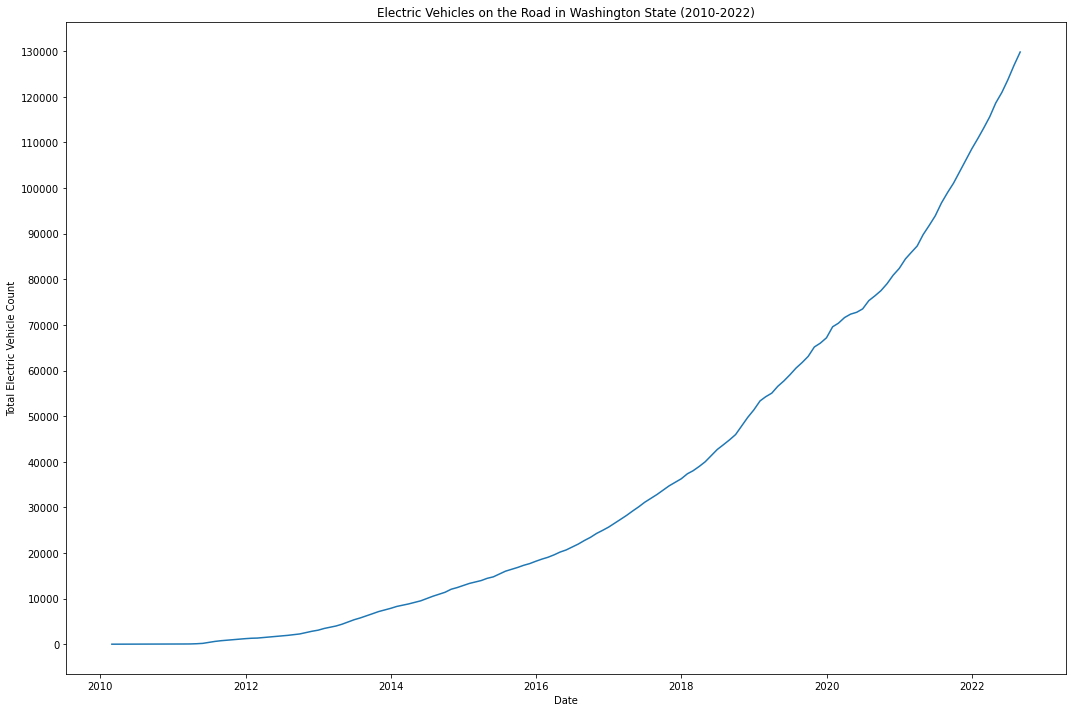

In [40]:
#plotting statewide EV Count
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x='transaction_date', y='State Total', data=df_cumsum, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Total Electric Vehicle Count')
ax.set_title('Electric Vehicles on the Road in Washington State (2010-2022)')
ax.set_yticks(range(0,140000,10000))
plt.tight_layout()
plt.savefig('images/output_103_0.png', facecolor='white');

As we can see above, the amount of electric vehicles on Washington State roads have been increasing exponentially over the past 11 years. On a high level, this confirms that Washington State has the necessary demand trend for electric vehicles to make investing in it profitable for an EV charging company. 

Since our data goes back as far as 2010, the count starts with 0 in 2010. However, it is important to note that this does not necessarily mean that there weren't any electric vehicles on the road in 2010. We are simply taking 2010 as our starting point and therefore the counts are relative.

## Electric Vehicles on the Road Over Time by County

Now that we looked at the statewide trend, we can start looking at individual counties. Since we have limited time for this analysis, we will be limiting our analysis to the top 10 counties that had the most electric vehicle purchases in the past 10 years.

In [41]:
df['county'].value_counts()

King            86596
Snohomish       17817
Pierce          13009
Clark            9188
Kitsap           5694
Thurston         5680
Spokane          4061
Whatcom          4017
Benton           1899
Skagit           1719
Island           1697
Clallam           946
Jefferson         904
San Juan          851
Cowlitz           813
Yakima            776
Chelan            758
Mason             757
Lewis             615
Franklin          539
Grays Harbor      529
Grant             416
Walla Walla       392
Kittitas          386
Douglas           278
Whitman           232
Klickitat         230
Pacific           191
Stevens           189
Skamania          166
Okanogan          154
Asotin             69
Adams              53
Pend Oreille       45
Wahkiakum          40
Lincoln            33
Ferry              30
Columbia           17
Garfield            4
Name: county, dtype: int64

In [42]:
top_ten_counties = ['King', 'Snohomish', 'Pierce', 'Clark', 'Thurston', 
                  'Kitsap', 'Whatcom', 'Spokane', 'Benton', 'Skagit']

In [43]:
#filtering out counties to keep top 10
df_cumsum = df_cumsum.loc[:, ['transaction_date', *top_ten_counties]]
# df_cumsum.head()

In [44]:
df_cumsum = df_cumsum.reset_index()
# import os
# from datetime import date
# today = date.today().strftime("%m-%d-%Y")

# path = './data'
# output_file = os.path.join(path,f'vehicles_on_the_road-{today}.csv')
# df_cumsum.to_csv(output_file, index=False)

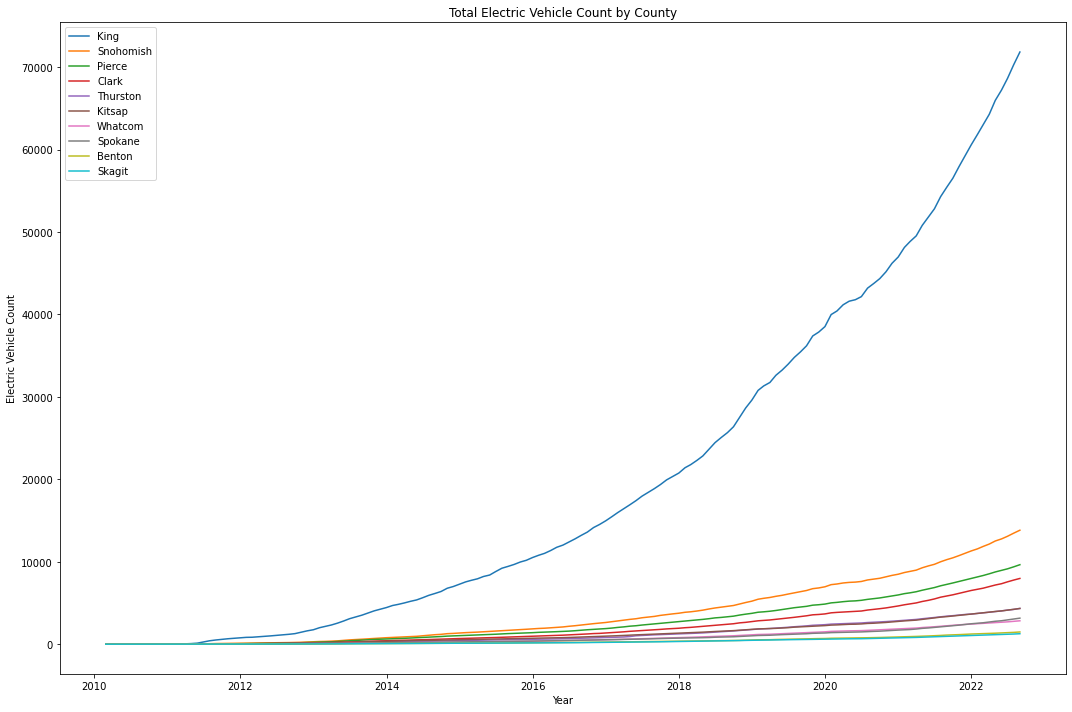

In [45]:
#plotting county trends
fig, ax = plt.subplots(figsize=(15,10))
for county in top_ten_counties:
    sns.lineplot(x='transaction_date', y=county, data=df_cumsum, ax=ax, 
                 label=county)
ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicle Count')
ax.set_title('Total Electric Vehicle Count by County')
ax.legend()
# df_cumsum.plot()
plt.tight_layout();
plt.savefig('images/output_110_0.png', facecolor='white')

Here, we can see that out of the top 10 most EV purchasing counties, King County has been growing much faster compared to others. This is expected since King County includes Seattle, which is the largest city by population in Washington State. Due to the scale differences between King County and the other 9 counties, it is difficult to see how these 9 counties compare to each other.

## Electric Vehicles on the Road Over Time (Excluding King County)

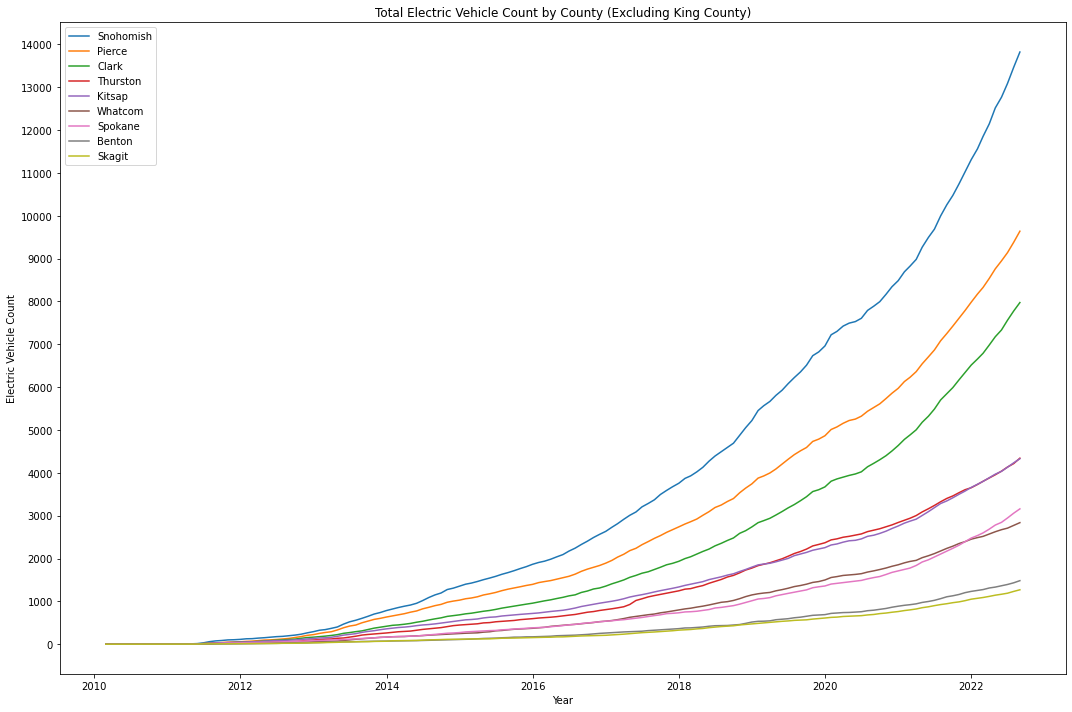

In [46]:
#plotting county trends except for King County
top_ten_counties.remove('King')

fig, ax = plt.subplots(figsize=(15,10))
for county in top_ten_counties:
    sns.lineplot(x='transaction_date', y=county, data=df_cumsum, ax=ax, 
                 label=county)
ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicle Count')
ax.set_title('Total Electric Vehicle Count by County (Excluding King County)')
ax.set_yticks(range(0,15000,1000))
ax.legend()
plt.tight_layout();
plt.savefig('images/output_113_1.png', facecolor='white')

When we exclude King County, we can see that Snohomish County is leading the charge in electric vehicle purchases followed by Pierce and Clark County. 

In [47]:
top_ten_counties += ['King']

## Most Purchased Car Models by County

Another important piece of information that can be relevant for an electric charging company is what the most purchased electric vehicle models are in each of these counties to decide on additional factors. These may include: 

- Whether to include adapters for different connector types (Tesla, CCS, CHAdeMO etc.)
- What kind of charging station to build (level 1, level 2, level 3)
- Spacing of chargers based on the size of vehicles

In [48]:
def model_counts_by_county(df=df, top_n=10, county_list=top_ten_counties):
    
    """Function plots top n most purchased models as a bar plot for each of 
    the counties provided.
    -------------------------------
    Arguments:
    df: class: pandas.DataFrame, default: df
    Dataframe containing title transactions for all counties.
    
    top_n: int, default: 10
    Number of most purchased models to plot.
    
    county_list: list, default: top_ten_counties
    The counties that will be analyzed.
    """
    
    fig, ax = plt.subplots(figsize=(10, 60), nrows=len(county_list))
    
    for i, county in enumerate(county_list):
        df_county = df[(df['county']==county) & 
                       (df['transaction_type']=='Original Title')]
        model_count_df = pd.DataFrame(df_county['model'].value_counts()).reset_index()
        model_count_df.columns=['model', 'count']
        sns.barplot(x='model', y='count', data=model_count_df.head(top_n), 
                    ax=ax[i])
        ax[i].set_title(f'Top {top_n} Most Purchased Models in {county} County (2010-2022)')
    plt.tight_layout();

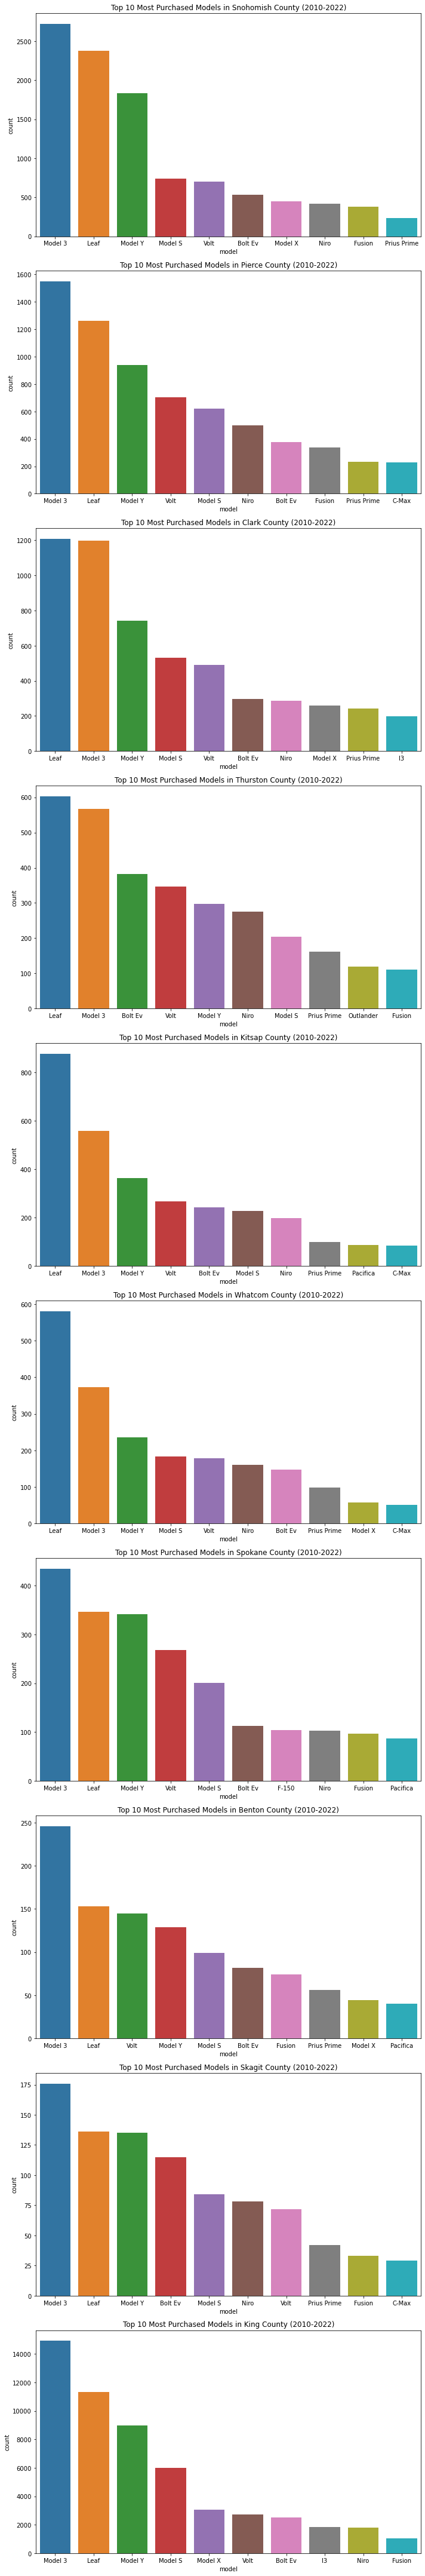

In [49]:
model_counts_by_county()
plt.savefig('images/output_119_0.png', facecolor='white')

Nissan Leaf and Tesla Model 3 are the most purchased vehicles in each of these counties. Nissan Leaf was released in December 2010 and is widely considered to be the first mass-market electric vehicle. Tesla's Model 3 is a relatively lower priced luxury electric vehicle that was designed to appeal to the mass market as well. Considering these factors, it is not surprising that these vehicles are the most purchased vehicles in each county.

# MODEL

## Preprocessing/ Defining Functions

In [50]:
df_cumsum = df_cumsum.set_index('transaction_date').resample('M').asfreq()

In [51]:
# df_cumsum.info()

### Separating Data for Each County

##### We will be creating time series models for the top ten counties. This requires us to break down the dataframe we have into smaller dataframes for each county.

In [52]:
def separate_data_by_county(county, df):
    """Function separates the given dataframe by county and returns the 
    separated dataframe.
    -------------------------------
    Arguments:
    county: str
    Name of county that will be separated from the dataframe. 
    
    df: class: pandas.DataFrame
    Dataframe that contains data for all counties. The specified county will 
    be separated from this DataFrame. 
    """
    
    df_county = pd.DataFrame(df.loc[:, county])
    df_county.columns=["EV's on the Road"]
    df_county.head()
    return df_county

In [53]:
#separating data by county and parsing this information to a dictionary
county_information = {}
for county in top_ten_counties:
    county_information[county] = {}
    county_information[county]['df']=separate_data_by_county(county, df_cumsum)

In [54]:
#separating data by county and parsing this information to a dictionary
county_dfs = {}
for county in top_ten_counties:
    county_dfs[county] = separate_data_by_county(county, df_cumsum)

### Functionizing the Evaluation of Models

Before modelling, one of the functions we will need is a function that will show us the various statistics so that we can evaluate the performance of the model.

In [55]:
def evaluate_model(model):
    """Function returns the model summary and diagnostics information to aid 
    the evaluation of the given model's performance.
    -------------------------------
    Arguments:
    model: SARIMAX or ARIMA model object
    Model variable to evaluate (Time series models for both pmdarima and 
    statsmodels are supported. 
    """
    
    display(model.summary())
    model.plot_diagnostics()
    plt.tight_layout();

### Creating a Function for train_test_split & plotting

We will be splitting the time series into two: a training set and a testing set. This will allow us to validate the performance of the models.

In [56]:
def train_test_split_ts (df, train_size, test_size):
    
    """Function splits a given DataFrame into two sets based on the given 
    train and test sizes so that the data can be used for validation.
    -------------------------------
    Arguments:
    df: class: pandas.DataFrame
    The base dataframe that will be getting split.
    
    train_size: float
    The size of the desired training set (for example: 0.80)
    
    test_size: float
    The size of the desired training set (for example: 0.20)
    """
    
    train_end_idx = int(round(len(df)*train_size,0))
    train_set = df.iloc[0:train_end_idx,:]["EV's on the Road"]
    test_set = df.iloc[train_end_idx:,:]["EV's on the Road"]
    return train_set, test_set

Additionally, to visualize these splits we will need a plotting function.

In [57]:
def plot_train_test_split(train_data, test_data, county):
    
    """Function plots the training and testing data for visual inspection.
    -------------------------------
    Arguments:
    train_data: pandas.Series
    The training set of data to be plotted.
    
    test_data: pandas.Series
    The test set of data to be plotted.
    
    county: str
    Name of the county that the training and testing data belongs to. This 
    string is used to set the title of the axes.
    """
    
    train_data.plot(label='Train Data')
    test_data.plot(label='Test Data')
    ax=plt.gca()
    ax.set_xlabel('Year')
    ax.set_ylabel('Electric Vehicles on the Road')
    ax.set_title(f'Electric Vehicles on the Road in {county} County')
    ax.legend();

### Creating a Function for Getting Forecasts

For validation purposes we will be getting the forecast from our model for the test period and will be plotting it against the actual test data.

In [58]:
def get_forecast(model, train_data, test_data, plot=True):
    
    """Function gets forecasted values from a given model and plots them for 
    visual inspection. The length of the forecasts are dependent on the length 
    of the test data. The forecasted values are returned in a DataFrame format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model that the forecast is to be received from. 
    
    train_data: pandas.Series
    The training set of data used in training the model.
    
    test_data: pandas.Series
    The testing set of data used for validating the model.
    
    plot: bool, default=True
    Option to plot the forecasted values along with observed values 
    (train_data and test_data).
    """
    
    #creating a df with the forecast information
    forecast_df = model.get_forecast(steps=len(test_data)).conf_int()
    forecast_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    forecast_df['Forecasts'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=train_data, color='black', ax=ax)
            sns.lineplot(data=forecast_df, x=forecast_df.index, 
                         y='Forecasts', color='blue', ax=ax, 
                         label='Forecasted Data', ls='--')
            sns.lineplot(data=test_data, color='purple', ax=ax, 
                         label='Actual Data', ls='-.')
            ax.fill_between(forecast_df.index, 
                            y1=forecast_df['Lower Confidence Interval'], 
                            y2=forecast_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.legend(loc=2)
            plt.show();
    return forecast_df

### Defining a Function for Getting Predictions for Future

Lastly, we will also be needing a function similar to the get_forecast function that will be used for getting predictions for the future and plotting for visualization.

In [59]:
def get_prediction(model, df, test_data, county_name, plot=True):
    
    """Function gets predicted values from a given model and plots them for 
    visual inspection. The length of the predictions are dependent on the 
    length of the test data. The forecasted values are returned in a DataFrame 
    format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model to be used for making predictions.
    
    df: pandas.DataFrame
    DataFrame that contains all observed data.
    
    test_data: pandas.Series
    The testing set of data used for validating the model (dictates the length
    of predictions).
    
    plot: bool, default=True
    Option to plot the predicted values along with observed values.
    """
    
    #creating a df with the prediction information
    prediction_df = model.get_forecast(steps=len(test_data)).conf_int()
    prediction_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    prediction_df['Predictions'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=df, ax=ax)
            sns.lineplot(data=prediction_df, x=prediction_df.index, 
                         y='Predictions', color='orange', ax=ax, 
                         label='Predicted Data', ls='--')
            ax.fill_between(prediction_df.index, 
                            y1=prediction_df['Lower Confidence Interval'], 
                            y2=prediction_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.set_ylabel('Electric Vehicles on the Road')
            ax.set_title(f'Predicted Electric Vehicle Count for {county_name}')
            plt.show();
    return prediction_df

## King County


### Seasonality Check

Prior to starting modeling, it is important to decompose the data to get a better sense of the trend and seasonality components of it.

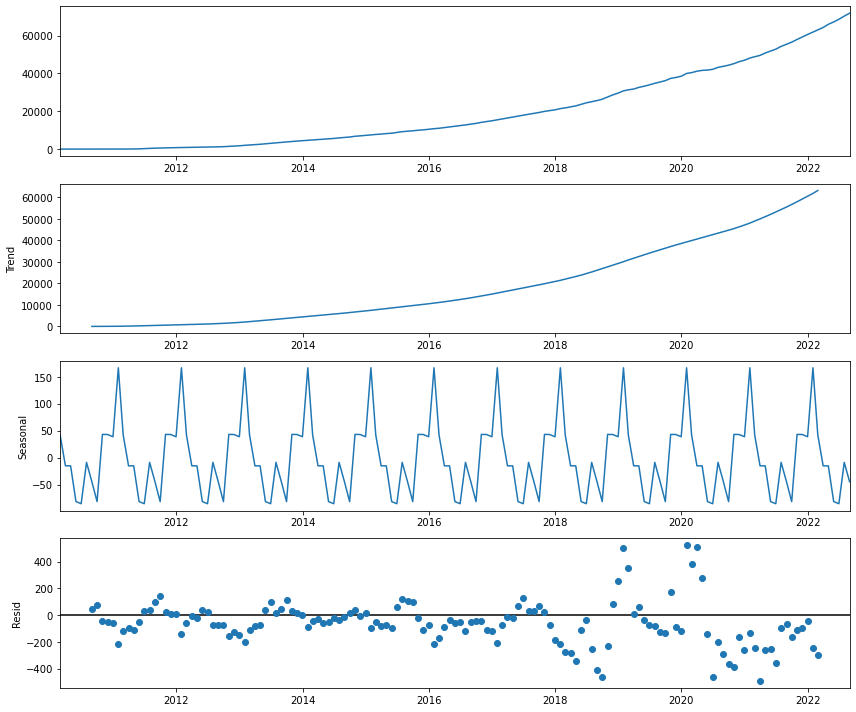

In [60]:
import statsmodels.tsa.api as tsa

plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['King']['df'])
decomp.plot();

Not surprisingly, the electric vehicle count for King County has an upward trend. Additionally, we can see that there is seasonality to the data as well. We can now move onto creating the training and testing sets for validation.

### train_test_split

#### After multiple iterations, we found that the 0.80-0.20 split of the data belonging to King County resulted in the best performance.(80% train, 20%test)


In [61]:
#splitting dataset into train and test sets for validation
train_king, test_king = train_test_split_ts(county_information['King']['df'], 
                                            0.80, 0.20)

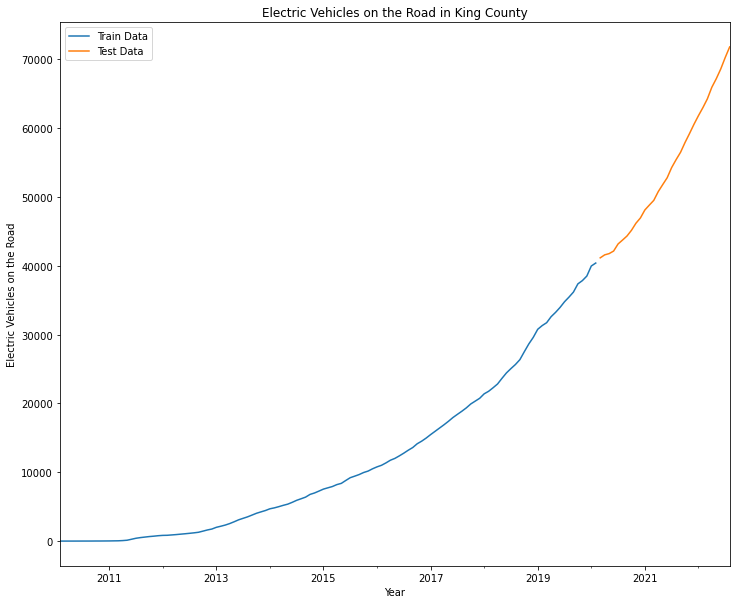

In [62]:
#plotting the split
plot_train_test_split(train_king, test_king, 'King')

### Finding Best Parameters with Auto-Arima


To have a model that can accurately predict future values, we need to optimize the p,d,q values of the models for each county and validate. In order to achieve this programmatically, we will be using the pmdarima library.

In [63]:
import pmdarima as pm

In [64]:
auto_model = pm.auto_arima(train_king, start_p=0, d=1, start_q=0, max_p=4, 
                           max_d=3, max_q=4, start_P=0, start_Q=0, max_P=3, 
                           max_D=3, max_Q=3, m=12)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  121
Model:             SARIMAX(0, 1, 3)x(1, 1, [], 12)   Log Likelihood                -676.973
Date:                             Tue, 18 Oct 2022   AIC                           1365.947
Time:                                     23:33:32   BIC                           1382.039
Sample:                                 02-28-2010   HQIC                          1372.472
                                      - 02-29-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    123.8554     35.572      3.482      0.000      54.136     193.574
ma.L1          0.4067      0.072      5.673      0.000       0.266       0.547
ma.L2          0.1313      0.062      2.114      0.034       0.010       0.253
ma.L3          0.2761      0.079      3.482      0.000       0.121       0.432
ar.S.L12      -0.4052      0.082     -4.915      0.000      -0.567      -0.244
sigma2      1.593e+04   1559.281     10.215      0.000    1.29e+04     1.9e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               120.59
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              17.81   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (0, 1, 3) for the ARIMA order and (1, 1, [], 12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                  121
Model:             SARIMAX(0, 1, 3)x(1, 1, [], 12)   Log Likelihood                -614.267
Date:                             Tue, 18 Oct 2022   AIC                           1238.534
Time:                                     23:33:32   BIC                           1251.355
Sample:                                 02-28-2010   HQIC                          1243.716
                                      - 02-29-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5679      0.076      7.452      0.000       0.419       0.717
ma.L2          0.3312      0.090      3.685      0.000       0.155       0.507
ma.L3          0.3560      0.117      3.044      0.002       0.127       0.585
ar.S.L12      -0.1937      0.094     -2.071      0.038      -0.377      -0.010
sigma2      2.112e+04   2164.639      9.758      0.000    1.69e+04    2.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):               106.89
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):              12.19   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

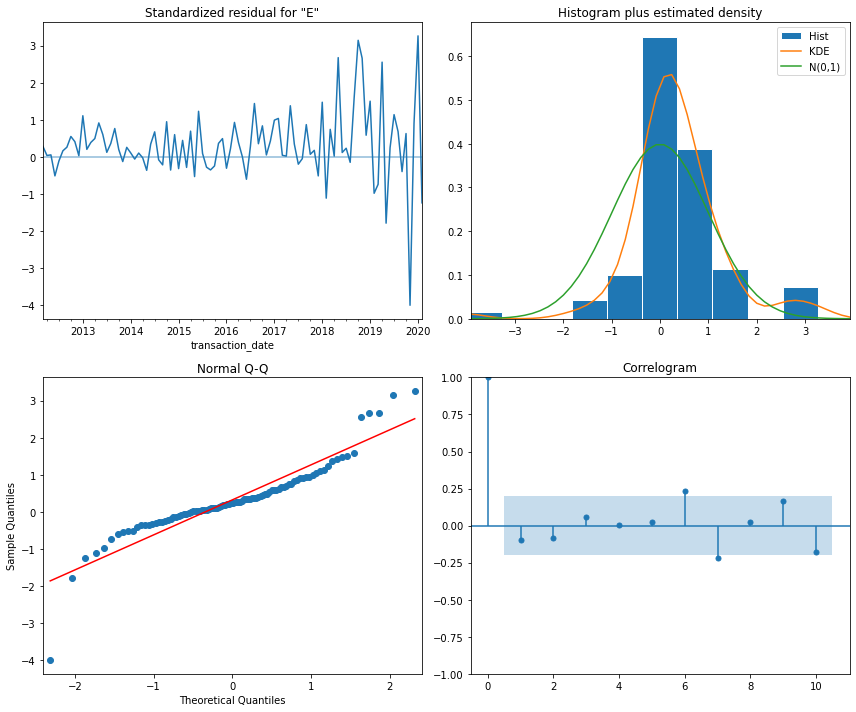

In [66]:
model = SARIMAX(train_king, order=(0, 1, 3), 
                seasonal_order=(1, 1, [], 12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

Here, looking at the residual information, we can see that they are very close to having a normal distribution. Additionally, there is no longer an obvious seasonality based on the correlogram and the standardized residuals. The coefficient p-values also suggest that they are statistically significant. These results suggest that the model is satisfactory to move onto validation.

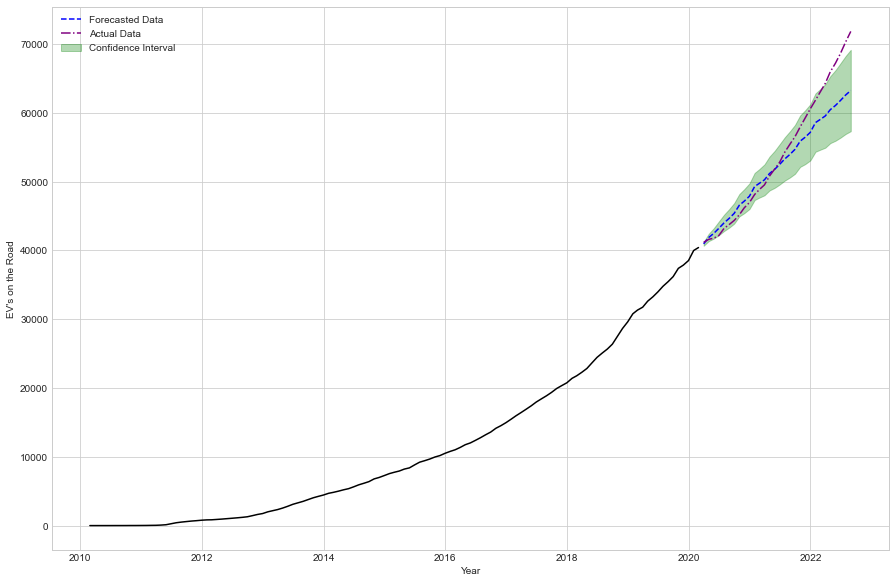

In [67]:
df_king_forecast = get_forecast(model, train_king, test_king, plot=True)

### Future Predictions

#### Fitting Model to All Observed Data

Now that we know that our model can accurately make predictions about the future electric vehicle counts in each county, we can use the same parameters to build a model on the whole observed dataset without splitting it into train/test sets.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                  151
Model:             SARIMAX(0, 1, 3)x(1, 1, [], 12)   Log Likelihood                -850.563
Date:                             Tue, 18 Oct 2022   AIC                           1711.126
Time:                                     23:33:33   BIC                           1725.307
Sample:                                 02-28-2010   HQIC                          1716.887
                                      - 08-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5443      0.067      8.113      0.000       0.413       0.676
ma.L2          0.4833      0.063      7.724      0.000       0.361       0.606
ma.L3          0.2547      0.068      3.724      0.000       0.121       0.389
ar.S.L12      -0.3028      0.057     -5.359      0.000      -0.414      -0.192
sigma2      4.272e+04   4465.409      9.566      0.000     3.4e+04    5.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):                12.23
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):              21.39   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

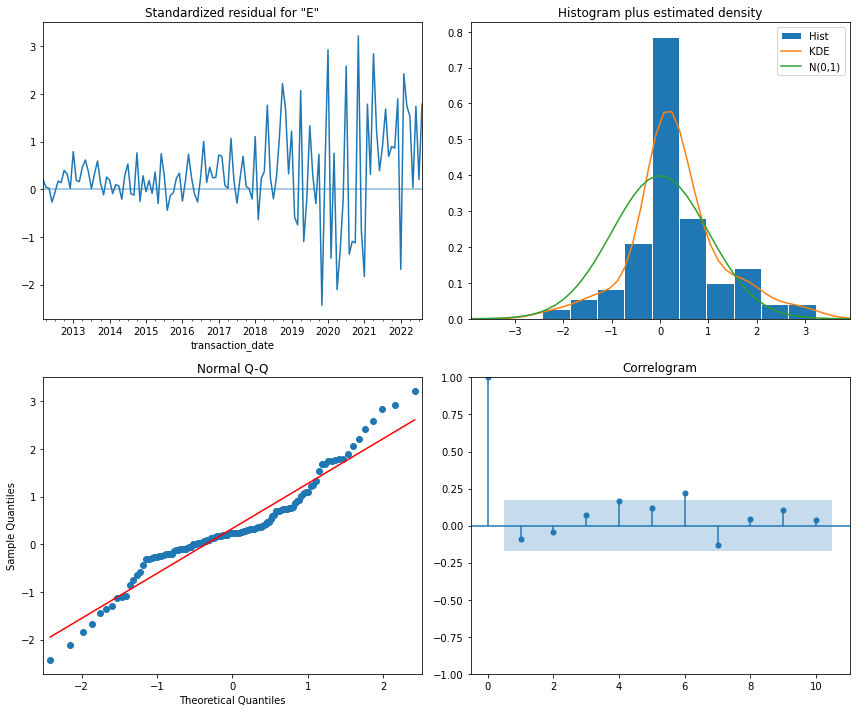

In [68]:
model = SARIMAX(county_information['King']['df'], order=(0, 1, 3), 
                seasonal_order=(1, 1, [], 12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

Above we can see that the residuals for this model are less normally distributed compared to the test model. However, they are still fairly close to having a normal distribution. Additionally, there is no longer an obvious seasonality based on the correlogram and the standardized residuals. The coefficient p-values also suggest that they are statistically significant.

#### Plotting & Saving Predictions


Using our model, we can predict the future counts of electric vehicles in King County and plot them. 

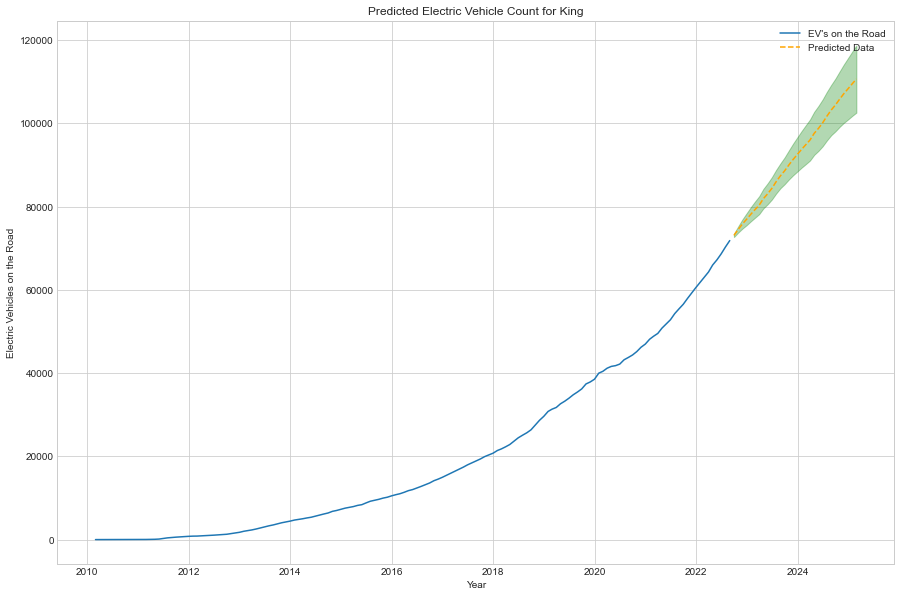

In [69]:
#creating a df of predictions and plotting
df_king_preds = get_prediction(model, county_information['King']['df'], 
                               test_king, 'King', plot=True)

The model is predicting that the amount of electric vehicles in King County are going to keep increasing almost linearly based on the mean values. If we look at the upper confidence interval though, we can see that the increase could keep an exponential pattern.

In [70]:
#saving predictions df to dict for later use
county_information['King']['Predictions'] = df_king_preds

## Snohomish County

### Seasonality Check

In [71]:
# plt.rcParams['figure.figsize']=(12,6)
decomp = tsa.seasonal_decompose(county_information['Snohomish']['df'])
# decomp.plot();

Above we can see that there is a clear trend upwards in electric vehicle counts in Snohomish county. Additionally, we can see that there is a relatively small seasonality to it.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Snohomish County resulted in the best performance. (75% train, 25% test)

In [72]:
#splitting dataset into train and test sets for validation
train_sno, test_sno = train_test_split_ts(county_information['Snohomish']['df'],
                                          0.75, 0.25)

In [73]:
#plotting train and test sets
# plot_train_test_split(train_sno, test_sno, 'Snohomish')

### Finding Best Parameters with Auto-Arima

In [74]:
#finding best parameters
auto_model = pm.auto_arima(train_sno, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
# auto_model.summary()

The best parameters (based on the AIC score) were (3, 1, 1) for the ARIMA order and (1, 0, [], 12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [75]:
#fitting SARIMAX model with best params
model = SARIMAX(train_sno, order=(3, 1, 1), seasonal_order=(1, 0, [], 12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
# evaluate_model(model)

Above, we can see that the residuals are almost perfectly normally distributed. This indicates that the parameters we chose worked in removing the trend and the seasonality of the data. Next, we can move onto visually validating the model.

In [76]:
# df_sno_forecast = get_forecast(model, train_sno, test_sno, plot=False)

### Future Predictions

Once again, we can use the same parameters found above for the entire observed data to make predictions on future values.

#### Fitting Model to All Observed Data

In [77]:
model = SARIMAX(county_information['Snohomish']['df'], order=(3, 1, 1), seasonal_order=(1, 0, [], 12),
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
# evaluate_model(model)

In [78]:
#getting and plotting predictions
df_sno_preds = get_prediction(model, county_information['Snohomish']['df'], 
                               test_sno, 'Snohomish', plot=False)

The model is predicting that the amount of electric vehicles in Snohomish county are going to keep rising in an exponential pattern.

In [79]:
#saving predictions
county_information['Snohomish']['Predictions'] = df_sno_preds

## Pierce County

### Seasonality Check

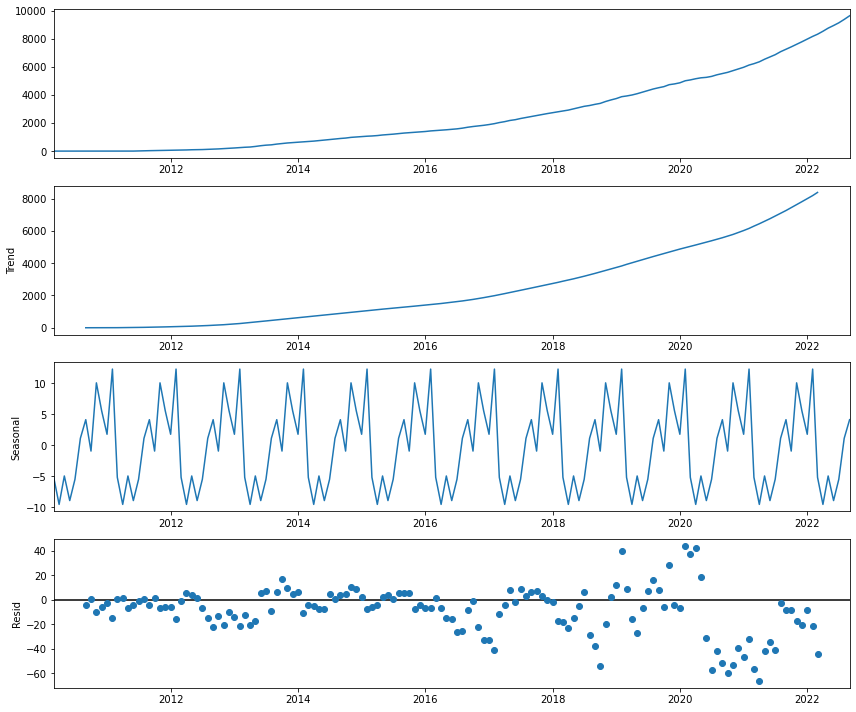

In [80]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Pierce']['df'])
decomp.plot();

We can see here that there is a clear upwards trend in the amount of electric vehicles in Pierce County. Additionally, there seems to be a relatively small seasonal component to the data as well.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Pierce County resulted in the best performance.

In [81]:
#splitting dataset into train and test sets for validation
train_pierce, test_pierce = train_test_split_ts(county_information['Pierce']['df'], 
                                            0.75, 0.25)

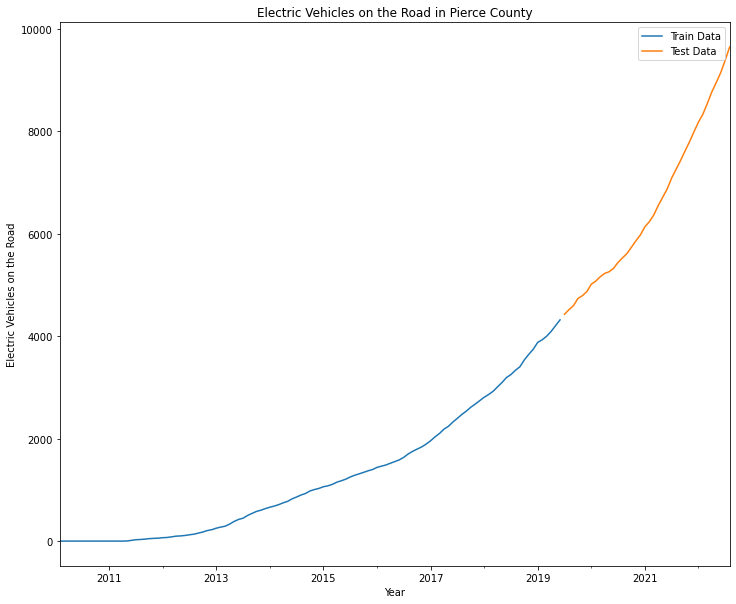

In [82]:
#plotting train and test sets
plot_train_test_split(train_pierce, test_pierce, 'Pierce')

### Finding Best Parameters with Auto-Arima

In [83]:
auto_model = pm.auto_arima(train_pierce, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  113
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -449.214
Date:                            Tue, 18 Oct 2022   AIC                            906.428
Time:                                    23:34:07   BIC                            917.302
Sample:                                02-28-2010   HQIC                           910.840
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9947      0.010     99.918      0.000       0.975       1.014
ma.L1         -0.6167      0.091     -6.743      0.000      -0.796      -0.437
ma.S.L12       0.4460      0.127      3.514      0.000       0.197       0.695
sigma2       168.3548     14.566     11.558      0.000     139.806     196.904
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               108.24
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              18.29   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Validate Model with Forecasts for Test Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  113
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -396.930
Date:                            Tue, 18 Oct 2022   AIC                            801.860
Time:                                    23:34:07   BIC                            812.200
Sample:                                02-28-2010   HQIC                           806.043
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0157      0.010    102.930      0.000       0.996       1.035
ma.L1         -0.7003      0.091     -7.710      0.000      -0.878      -0.522
ma.S.L12       0.3897      0.146      2.677      0.007       0.104       0.675
sigma2       188.9206     19.496      9.690      0.000     150.708     227.133
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                54.92
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               4.43   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

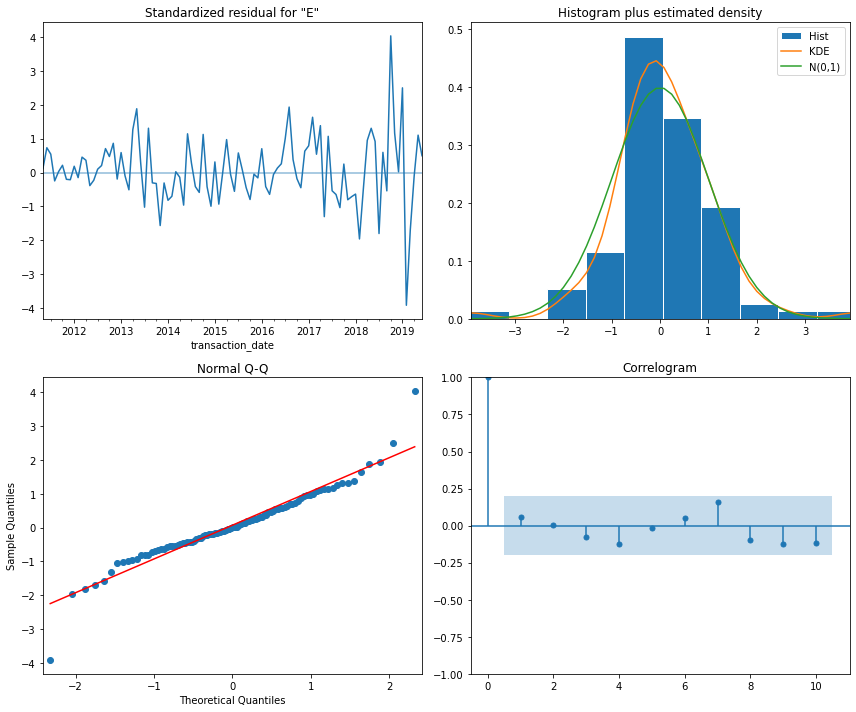

In [84]:
#fitting SARIMAX model with best params
model = SARIMAX(train_pierce, order=(1, 1, 1), seasonal_order=(0, 0, 1, 12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

Above, we can see that the residuals are almost perfectly normally distributed. This indicates that the parameters chosen above were successful in removing the seasonality and the trend. Additionally, even though some of the coefficients have values higher than 0.05 (our chosen alpha value), based on the AIC score these parameters resulted in the best model. So we will be moving on with this model.

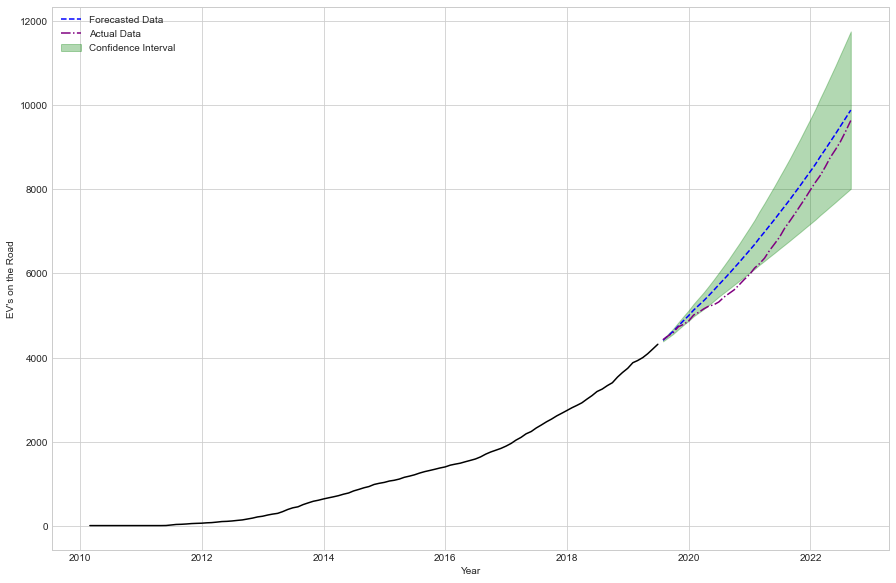

In [85]:
df_pierce_forecast = get_forecast(model, train_pierce, test_pierce, plot=True)

### Future Predictions

#### Fitting Model to All Observed Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  151
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -596.679
Date:                            Tue, 18 Oct 2022   AIC                           1201.358
Time:                                    23:34:08   BIC                           1213.009
Sample:                                02-28-2010   HQIC                          1206.093
                                     - 08-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0205      0.006    158.742      0.000       1.008       1.033
ma.L1         -0.6482      0.060    -10.753      0.000      -0.766      -0.530
ma.S.L12       0.2756      0.070      3.963      0.000       0.139       0.412
sigma2       375.7750     32.554     11.543      0.000     311.971     439.579
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                22.53
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               9.75   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

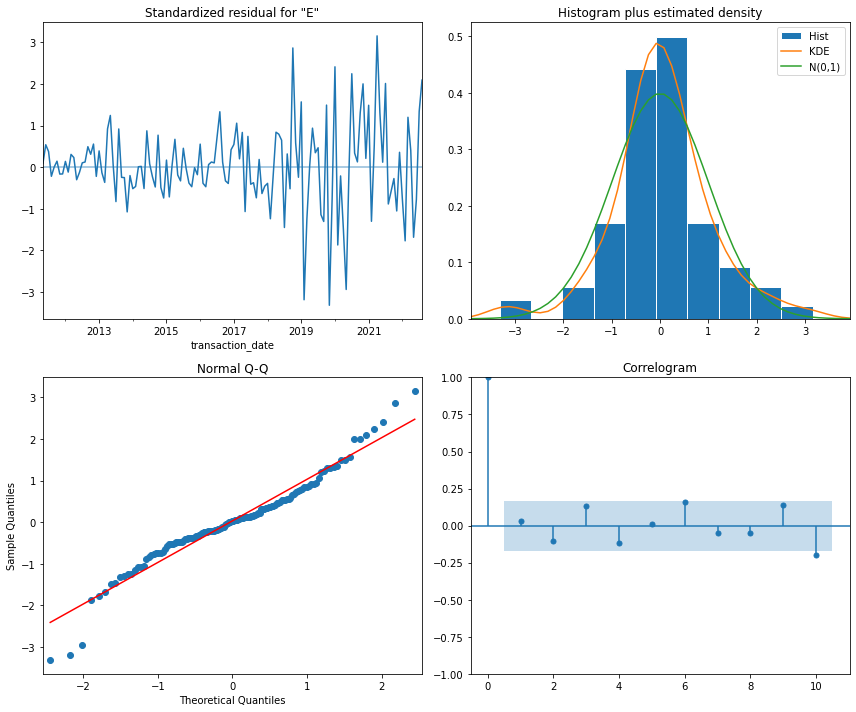

In [86]:
model = SARIMAX(county_information['Pierce']['df'], order=(1, 1, 1),
                seasonal_order=(0, 0, 1, 12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

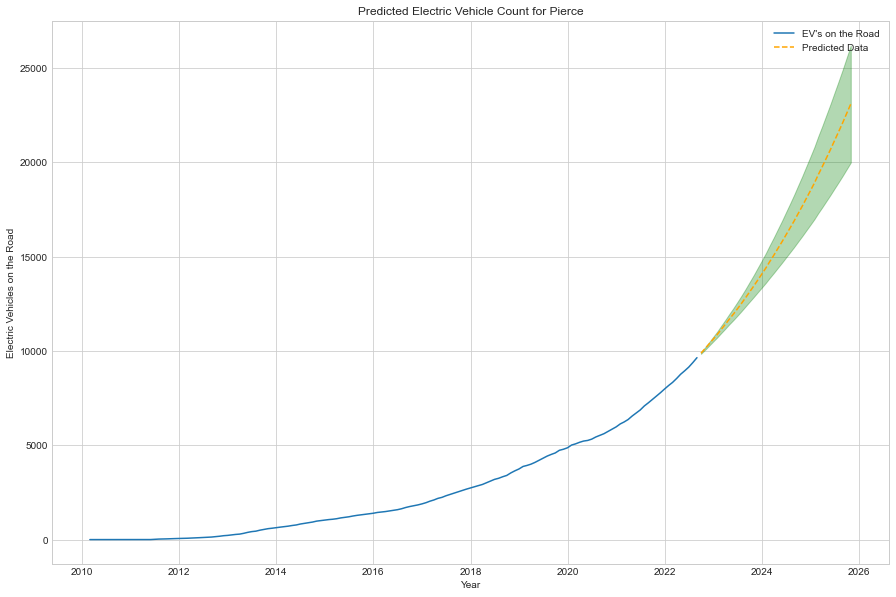

In [87]:
#getting and plotting predictions
df_pierce_preds = get_prediction(model, county_information['Pierce']['df'], 
                               test_pierce, 'Pierce', plot=True)

Our model is predicting that the growth in electric vehicles in Pierce County will keep an exponential growth pattern for the next few years.

In [88]:
#saving predictions
county_information['Pierce']['Predictions'] = df_pierce_preds

## Clark County

### Seasonality Check


In [89]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Clark']['df'])
# decomp.plot();

As is the case with the previous counties, the decomposition for Clark County's data also suggests that there is an upwards trend and a seasonal component.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Clark County resulted in the best performance.

In [90]:
#split data into train/test sets for validation
train_clark, test_clark = train_test_split_ts(county_information['Clark']['df'], 
                                            0.75, 0.25)

In [91]:
#plot the split
# plot_train_test_split(train_clark, test_clark, 'Clark')

### Finding Best Parameters with Auto-Arima


In [92]:
auto_model = pm.auto_arima(train_clark, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
# auto_model.summary()

The best parameters (based on the AIC score) were (1,1,1) for the ARIMA order and (1,0,[],12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [93]:
model = SARIMAX(train_clark, order=(1,1,1), seasonal_order=(1,0,[],12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
# evaluate_model(model)

The residuals are nearly normally distributed and based on the correlogram, the model was able to remove seasonality successfully.

In [94]:
df_clark_forecast = get_forecast(model, train_clark, test_clark, plot=False)

The model's forecast stays inline with the observed data from mid-2018 to early 2020. Around March of 2020, the observed data is lower than the forecasts. This may be due to the COVID-19 pandemic that affected much of the US at this date. Even though this is the case, the observed data stays well within the confidence interval. This indicates that our model is performing very well and that we can move onto fitting the model to all the observed data to make predictions on future values.

### Future Predictions

#### Fitting Model to All Observed Data

In [95]:
model = SARIMAX(county_information['Clark']['df'], order=(1,1,1), 
                seasonal_order=(1,0,[],12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
# evaluate_model(model)

The residuals are once again fairly normally distributed except for the portion of early 2020 to today. As discussed above, this may be due to the COVID-19 pandemic and the shutdowns that affected almost all industries including the electric vehicle market. 

#### Plotting & Saving Predictions

In [96]:
#getting/plotting predictions
df_clark_preds = get_prediction(model, county_information['Clark']['df'], 
                               test_clark, 'Clark', plot=False)

The model is predicting that the electric vehicle amount in Clark County will keep increasing exponentially in the coming years.

In [97]:
#saving predictions
county_information['Clark']['Predictions'] = df_clark_preds

## Thurston County

### Seasonality Check

In [98]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Thurston']['df'])
# decomp.plot();

Similar to the previous counties, Thurston County's electric vehicle count is also showing an upward trend along with a seasonality component.

### train_test_split

After multiple iterations, we found that the 0.80-0.20 split of the data belonging to Thurston County resulted in the best performance.

In [99]:
#splitting data into train/test sets for validation
train_thurston, test_thurston = train_test_split_ts(county_information['Thurston']['df'], 
                                            0.80, 0.20)

In [100]:
#plotting the split
# plot_train_test_split(train_thurston, test_thurston, 'Thurston')

### Finding Best Parameters with Auto-Arima

In [101]:
#finding best parameters
auto_model = pm.auto_arima(train_thurston, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
# auto_model.summary()

The best parameters (based on the AIC score) were (1,1,1) for the ARIMA order and (1,0,[],12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [102]:
model = SARIMAX(train_thurston, order=(1,1,1), seasonal_order=(1,0,[],12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
# evaluate_model(model)

In [103]:
df_thurston_forecast = get_forecast(model, train_thurston, test_thurston, 
                                    plot=False)

### Future Predictions

#### Fitting Model to All Observed Data

In [104]:
model = SARIMAX(county_information['Thurston']['df'], order=(1,1,1), 
                seasonal_order=(1,0,[],12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
# evaluate_model(model)

#### Plotting & Saving Predictions

In [105]:
#getting and plotting predictions
df_thurston_preds = get_prediction(model, county_information['Thurston']['df'], 
                               test_thurston, 'Thurston', plot=False)

The model is predicting that the amount of electric vehicles in Thurston County are going to keep increasing at a linear rate (based on the mean prediction). However, if we look at the upper and lower confidence intervals we also see the possibilities of an exponential increase and a leveling off.

In [106]:
#saving predictions
county_information['Thurston']['Predictions'] = df_thurston_preds

## Kitsap County

### Seasonality Check

In [107]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Kitsap']['df'])
# decomp.plot();

Electric vehicle count in Kitsap County, similar to previous counties, has an upward trend. It also is showing a seasonal pattern but it is relatively smaller compared to other counties.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Kitsap County resulted in the best performance.

In [108]:
#splitting data into train/test sets for validation
train_kitsap, test_kitsap = train_test_split_ts(county_information['Kitsap']['df'], 
                                            0.75, 0.25)

In [109]:
#plotting the split
# plot_train_test_split(train_kitsap, test_kitsap, 'Kitsap')

### Finding Best Parameters with Auto-Arima

In [110]:
#finding best parameters
auto_model = pm.auto_arima(train_kitsap, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
# auto_model.summary()

The best parameters (based on the AIC score) were (1, 1, 2) for the ARIMA order with no parameters for seasonality. This shows us that the models that had a seasonality order specified performed worse than this model. As discussed above, considering the relatively lower seasonality trend for Kitsap County this is not exactly a surprise. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [111]:
model = SARIMAX(train_kitsap, order=(1, 1, 2), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
# evaluate_model(model)

In [112]:
df_kitsap_forecast = get_forecast(model, train_kitsap, test_kitsap, plot=False)

The forecast and the observed data seem to be very close to each other in 2020 which validates that the model is ready to be fitted to all observed data to make future predictions.

### Future Predictions

#### Fitting Model to All Observed Data

In [113]:
model = SARIMAX(county_information['Kitsap']['df'], order=(1, 1, 2), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
# evaluate_model(model)

#### Plotting & Saving Predictions


In [114]:
#getting and plotting predictions
df_kitsap_preds = get_prediction(model, county_information['Kitsap']['df'], 
                               test_kitsap, 'Kitsap', plot=False)

Above, we can see that the model is predicting the amount of electric vehicles in Kitsap County to keep increasing exponentially. 

In [115]:
#saving predictions
county_information['Kitsap']['Predictions'] = df_kitsap_preds

## Spokane County

### Seasonality Check

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Spokane County resulted in the best performance.

In [116]:
#splitting data to train/test set for validation
train_spokane, test_spokane = train_test_split_ts(county_information['Spokane']['df'], 
                                            0.75, 0.25)

In [117]:
#plotting the split
# plot_train_test_split(train_spokane, test_spokane, 'Spokane')

### Finding Best Parameters with Auto-Arima

In [118]:
auto_model = pm.auto_arima(train_spokane, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
# auto_model.summary()

### Validate Model with Forecasts for Test Data

In [119]:
model = SARIMAX(train_spokane, order=(1, 1, 1), 
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
# evaluate_model(model)

In [120]:
df_spokane_forecast = get_forecast(model, train_spokane, test_spokane, plot=False)

As we can see the actual and forecasted data are close enough so we are going ahead with this model

### Future Predictions

#### Fitting Model to All Observed Data


In [121]:
model = SARIMAX(county_information['Spokane']['df'], order=(1, 1, 1), 
                enforce_invertibility=False, 
                enforce_stationarity=False).fit(maxiter=125)
# evaluate_model(model)

#### Plotting & Saving Predictions

In [122]:
#getting and plotting predictions
df_spokane_preds = get_prediction(model, county_information['Spokane']['df'], 
                               test_spokane, 'Spokane', plot=False)

Above, we can see that the model is predicting the electric vehicle count in Spokane County to keep increasing exponentially.

In [123]:
#saving predictions
county_information['Spokane']['Predictions'] = df_spokane_preds

## Whatcom County

### Seasonality Check

In [124]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Whatcom']['df'])
# decomp.plot();

Above, we can see that the electric vehicle amount in Whatcom, as is the case with all the prior counties, has an upward trend. The seasonality component seems to be relatively smaller compared to the previous counties.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Whatcom County resulted in the best performance.


In [125]:
#splitting data into train/test sets for validation
train_whatcom, test_whatcom = train_test_split_ts(county_information['Whatcom']['df'], 
                                            0.75, 0.25)

In [126]:
#plotting the split
# plot_train_test_split(train_whatcom, test_whatcom, 'Whatcom')

### Finding Best Parameters with Auto-Arima

In [127]:
#finding best parameters
auto_model = pm.auto_arima(train_whatcom, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
# auto_model.summary()

The best parameters (based on the AIC score) were (2,1,1) for the ARIMA order with no parameters for seasonality. This shows us that the models that had a seasonality order specified performed worse than this model. As discussed above, considering the relatively lower seasonality trend for Whatcom County this is not exactly a surprise. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [128]:
model = SARIMAX(train_whatcom, order=(2,1,1), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
# evaluate_model(model)

In [129]:
df_whatcom_forecast = get_forecast(model, train_whatcom, test_whatcom, plot=False)

Above, we can see that the forecasted values and the observed values are very close from mid-2018 to 2020. In early 2020, the forecasted values seem to be higher than the actual observed values which may be due to the COVID-19 pandemic and the many supply chain issues it caused. These issues may have affected the electric vehicle sales in Whatcom County causing this discrepancy. Additionally, the observed data is still well within the confidence interval so we can move onto fitting the model to all observed data.

### Future Predictions

#### Fitting Model to All Observed Data

In [130]:
model = SARIMAX(county_information['Whatcom']['df'], order=(2,1,1), 
                enforce_invertibility=False, enforce_stationarity=False).fit(maxiter=125)
# evaluate_model(model)

The p-values for the coefficients are all statistically significant based on an alpha of 0.05. Additionally, the residuals are nearly normally distributed with the far right tail of the Q-Q plot being an exception. Looking at the residuals over time, there doesn't seem to be any apparent seasonality.

#### Plotting & Saving Predictions

In [131]:
#getting and plotting predictions
df_whatcom_preds = get_prediction(model, county_information['Whatcom']['df'], 
                               test_whatcom, 'Whatcom', plot=False)

In [132]:
#saving predictions
county_information['Whatcom']['Predictions'] = df_whatcom_preds

## Benton County

### Seasonality Check

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Benton County resulted in the best performance.

In [133]:
#splitting the data to train/test sets for validation
train_benton, test_benton = train_test_split_ts(county_information['Benton']['df'], 
                                            0.75, 0.25)

In [134]:
#plotting the split
# plot_train_test_split(train_benton, test_benton, 'Benton')

### Finding Best Parameters with Auto-Arima

In [135]:
auto_model = pm.auto_arima(train_benton, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
# auto_model.summary()

The best parameters (based on the AIC score) were (4,1,1) for the ARIMA order. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data


In [136]:
model = SARIMAX(train_benton, order=(4,1,1), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
# evaluate_model(model)

C:\Users\0025PE744\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [137]:
df_benton_forecast = get_forecast(model, train_benton, test_benton, plot=False)

Above, we can see that the forecasted values and the observed values are very close from mid-2018 to 2020. In early 2020, the forecasted values seem to be higher than the actual observed values which may be due to the COVID-19 pandemic and the many supply chain issues it caused. These issues may have affected the electric vehicle sales in Benton County causing this discrepancy. 

### Future Predictions

#### Fitting Model to All Observed Data

In [138]:
model = SARIMAX(county_information['Benton']['df'], order=(4,1,1), 
                enforce_invertibility=False, 
                enforce_stationarity=False).fit(maxiter=125)
# evaluate_model(model)

#### Plotting & Saving Predictions


In [139]:
#getting and plotting predictions
df_benton_preds = get_prediction(model, county_information['Benton']['df'], 
                               test_benton, 'Benton', plot=False)

From the predictions, we can see that the EV counts in Benton County are expected to keep increasing exponentially in the coming years.

In [140]:
county_information['Benton']['Predictions'] = df_benton_preds

## Skagit County

### Seasonality Check


In [141]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Skagit']['df'])
# decomp.plot();

### train_test_split


After multiple iterations, we found that the 0.70-0.30 split of the data belonging to Island County resulted in the best performance.

In [142]:
#splitting dataset to train/test sets for validation
train_skagit, test_skagit = train_test_split_ts(county_information['Skagit']['df'], 
                                            0.70, 0.30)

In [143]:
#plotting the split
# plot_train_test_split(train_skagit, test_skagit, 'Skagit')

### Finding Best Parameters with Auto-Arima

In [144]:
# #finding best parameters
auto_model = pm.auto_arima(train_skagit, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
# auto_model.summary()

### Validate Model with Forecasts for Test Data

In [145]:
model = SARIMAX(train_skagit, order=(1,1,1),seasonal_order=(1,0,1,12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
# evaluate_model(model)

In [146]:
df_skagit_forecast = get_forecast(model, train_skagit, test_skagit, plot=False)

### Future Predictions

#### Fitting Model to All Observed Data

In [147]:
model = SARIMAX(county_information['Skagit']['df'], order=(1,1,1), seasonal_order=(1,0,1,12),
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
# evaluate_model(model)

In [148]:
#getting and plotting predictions
df_skagit_preds = get_prediction(model, county_information['Skagit']['df'], 
                               test_skagit, 'Skagit', plot=False)

As we can see above, the model is predicting that the electric vehicle counts in Island County will keep growing exponentially in the coming years.

In [149]:
#saving predictions
county_information['Skagit']['Predictions'] = df_skagit_preds

# INTERPRET

To be able to interpret our results correctly and find the counties with the most potential for investment, we need to take into account the existing charging infrastructure. As discussed in the introduction section, we will be gathering this information from the National Renewable Energy Laboratory's (NREL) API.

## Current Charger Infrastructure by County


### Accessing NREL API for Current Charger Information

In [151]:
df_chargers=pd.read_csv('./dataset/alt_fuel_stations.csv.gz')
df_chargers.head()

,fuel_type_code,station_name,street_address,intersection_directions,city,state,zip,plus4,station_phone,status_code,...,EV Pricing (French),LPG Nozzle Types,Hydrogen Pressures,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,ev_renewable_source,Restricted Access
0,ELEC,City of Lacey - City Hall Parking,420 College St,"At 3rd Ave SE, next to police station",Lacey,WA,98503,NaN,360-491-3214,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,ELEC,Seattle-Tacoma International Airport - General...,17801 Pacific Hwy S,"5th floor parking garage; rows D, G, and I",Seattle,WA,98188,NaN,206-787-5388,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,ELEC,Haggen Food & Pharmacy,1313 Cooper Point Rd SW,In front of the building on the left hand side,Olympia,WA,98502,NaN,360-754-1428,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,ELEC,Avista Corp,1411 E Mission Ave,NaN,Spokane,WA,99252,NaN,509-489-0500,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,ELEC,Steam Plant Grill,159 S Lincoln St,NaN,Spokane,WA,99201,NaN,509-777-3900,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [152]:
len(df_chargers)

1933

In [153]:
#getting planned charger count
df_chargers['status_code'].value_counts()

E    1687
T     244
P       2
Name: status_code, dtype: int64

In our charger dataframe we have a total of 1933 charging stations (2 planned). To be able to compare the existing infrastructure in each county, we need to figure out how many stations there are in each county. Unfortunately, the data that we have does not have county information but has the zipcode of each station. We can use these zipcodes to figure out in which county each of these stations are.

### Creating Zipcode Map to Find Counties

In [154]:
from uszipcode import SearchEngine

C:\Users\0025PE744\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [155]:
#Creating a dictionary that shows which county each zipcode is in
zipcodes_to_search = list(df_chargers['zip'].unique())
search = SearchEngine()
zip_map = {}
for zipcode in zipcodes_to_search:
    zip_info = search.by_zipcode(zipcode)
    zip_map[zipcode] = zip_info.values()[5].split()[0]

# zip_map

### Feature Engineering 'county' Column for df_chargers


In [156]:
#mapping county information for each charger based on zipcode
df_chargers['county'] = df_chargers['zip'].map(zip_map)
# df_chargers['county'].head()
# df_chargers.to_csv('charging_infra.csv')

### Saving Total Electrical Charger Count in Each County


Now that we know in which county each charging station is, we can see how many stations there are in each county and save this information.

In [157]:
df_charger_counts = pd.DataFrame(df_chargers['county'].value_counts())
df_charger_counts.reset_index(inplace=True)
df_charger_counts.columns=['County', 'Charger Count']
df_charger_counts.to_csv('df_charger_counts-07-13-2021.csv')
# df_charger_counts

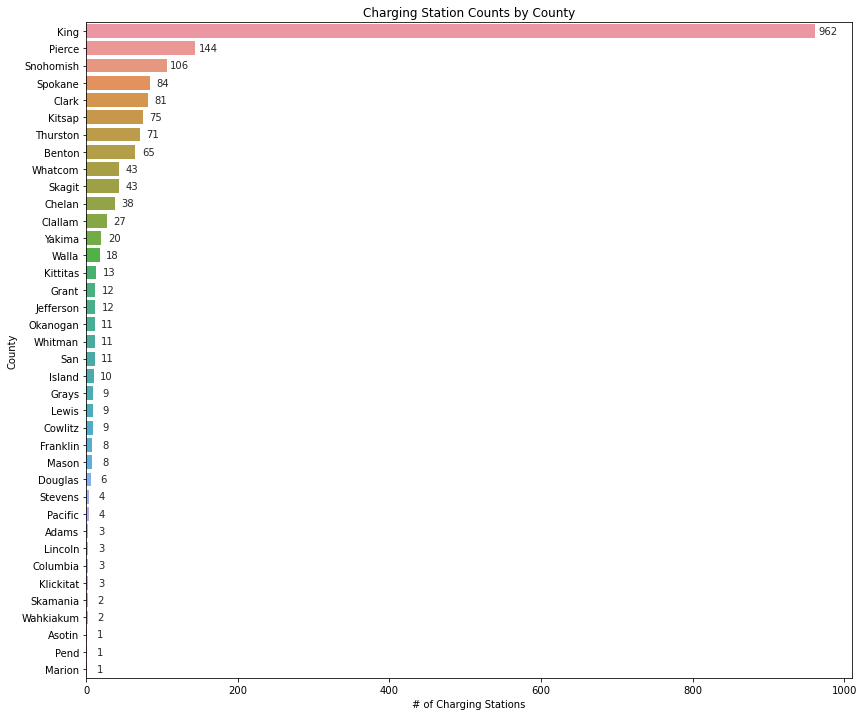

In [158]:
fig, ax = plt.subplots()
with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x='Charger Count', y='County', data=df_charger_counts, orient='h', ax=ax)
    ax.set_title('Charging Station Counts by County')
    ax.set_xlabel('# of Charging Stations')
    x_labels = list(df_charger_counts['Charger Count'])
    rects = ax.patches

    for rect, label in zip(rects, x_labels):
        width = rect.get_width()
        ax.text(rect.get_width()+17, rect.get_y()+0.5*rect.get_height(),
                 '%d' % int(width),
                 ha='center', va='center')
    plt.tight_layout();
plt.savefig('images/charger_counts.png', facecolor='white')

Above, we can see that King County has by far the most amount of chargers compared to other counties followed by Pierce and Snohomish.

## County Comparison


### Creating a DataFrame for Comparison

To be able to accurately compare each county, we need to put all of the information we have been gathering together in one dataframe. For each county, we will be looking at how many electric vehicles there are today and in August 31, 2023 to find how many cars will be getting added over the next 2 years as well as what the ratios of these counts are to the number of existing charging stations.

In [159]:
comparison_df=pd.DataFrame()
i=0
for county in top_ten_counties:
    comparison_df.loc[i, 'County']=county
    
    comparison_df.loc[i, 'EV Count for 2022-08-01']= \
    county_information[county]['df']["EV's on the Road"][-1]
    
    comparison_df.loc[i, 'EV Prediction for 2024-08-31'] = \
    round(county_information[county]['Predictions']['Predictions'][26],0)
    
    comparison_df.loc[i, 'Existing Charger Count'] = \
    int(df_charger_counts[df_charger_counts['County']==county]['Charger Count'])
    i+=1

comparison_df['Chargers per EV'] = \
round(comparison_df['Existing Charger Count']/\
      comparison_df['EV Prediction for 2024-08-31'],3)

comparison_df['EVs per Charger'] = \
round(comparison_df['EV Prediction for 2024-08-31']/\
      comparison_df['Existing Charger Count'],0)

comparison_df['EVs Added (Today-2024)'] = \
comparison_df['EV Prediction for 2024-08-31'] - comparison_df['EV Count for 2022-08-01']

comparison_df.sort_values('EV Prediction for 2024-08-31', ascending=False, 
                          inplace=True)
comparison_df.set_index('County', inplace=True)
comparison_df

,EV Count for 2022-08-01,EV Prediction for 2024-08-31,Existing Charger Count,Chargers per EV,EVs per Charger,EVs Added (Today-2024)
County,,,,,,
King,71830.0,107134.0,962.0,0.009,111.0,35304.0
Snohomish,13824.0,26527.0,106.0,0.004,250.0,12703.0
Pierce,9641.0,18073.0,144.0,0.008,126.0,8432.0
Clark,7975.0,14702.0,81.0,0.006,182.0,6727.0
Thurston,4342.0,7852.0,71.0,0.009,111.0,3510.0
Spokane,3159.0,7727.0,84.0,0.011,92.0,4568.0
Kitsap,4330.0,7697.0,75.0,0.010,103.0,3367.0
Whatcom,2837.0,4813.0,43.0,0.009,112.0,1976.0
Benton,1483.0,2861.0,65.0,0.023,44.0,1378.0


As we can see above, according to our models, we are predicting that most amount of electric vehicles will be joining the roads in King County. However, the most amount of charging stations are also in King County. This is not exactly unexpected since the largest city in Washington State, Seattle, is in King County as well. 

Therefore, instead of looking at raw counts, calculating the ratio between electric vehicles to charging stations will allow us to find the best counties for investing. The "EVs per Charger" column contains the ratio between the count of future electric vehicles to the count of chargers that exist today. For each county, a large value in this column would suggest that there will be more of a demand for chargers in this county compared to others.

In [160]:
col_list = list(comparison_df.columns)
col_list.remove('Chargers per EV')

In [161]:
for col in col_list:
    comparison_df[col] = comparison_df[col].astype('int64')

In [162]:
comparison_df.sort_values('EVs per Charger', ascending=False, inplace=True)
comparison_df.style.background_gradient(axis=0, subset=['EVs per Charger'], 
                                        cmap='RdYlGn')
# comparison_df.style.applymap('green', subset=pd.IndexSlice['Island'])

,EV Count for 2022-08-01,EV Prediction for 2024-08-31,Existing Charger Count,Chargers per EV,EVs per Charger,EVs Added (Today-2024)
County,,,,,,
Snohomish,13824,26527,106,0.004000,250,12703
Clark,7975,14702,81,0.006000,182,6727
Pierce,9641,18073,144,0.008000,126,8432
Whatcom,2837,4813,43,0.009000,112,1976
King,71830,107134,962,0.009000,111,35304
Thurston,4342,7852,71,0.009000,111,3510
Kitsap,4330,7697,75,0.010000,103,3367
Spokane,3159,7727,84,0.011000,92,4568
Skagit,1270,2530,43,0.017000,59,1260


When we sort by "EVs per Charger" column, we see that Snohomish County followed by Clark have by far the highest values. This suggests that these counties will have more demand for charging stations in the future. 

However, this does not show us the full picture. From our discussions with a electric charging company representative, we learned that additional factors such as the ones below may affect the decision to establish a charging station:

- Proximity to airports
- Proximity to highway entrances
- Proximity to commercial centers/office buildings

Airports generate a lot of traffic with a lot of people using rideshare services such as Uber or Lyft to get to or leave the airport. Charging stations close to airports tend to attract drivers who are working as rideshare drivers while they are waiting for their next passenger. 

Highway entrances are also important since highways inherently have a lot of traffic on them and people travelling long distances may need to charge up (sometimes multiple times) along the highway corridor. Additionally, drivers may want to charge their vehicles prior to getting on the highway.

According to Forbes, "80% of EV charging is done at home —almost always overnight— or while a car is parked during the workday"[³](https://www.forbes.com/wheels/news/jd-power-study-electric-vehicle-owners-prefer-dedicated-home-charging-stations/). This makes it incredibly important for public charging stations to be in close proximity to commercial centers and office buildings so that people shopping or working can charge their cars in the meantime.

Our analysis is at the county level and therefore we are not looking at specific locations within the counties to properly take these factors into account (see Limitations & Next Steps section). However, at a high level, we can still factor these into our analysis (see below).

### Top 3 County Comparison

Snohomish County contains Everett (which is the 7th largest city in WA State) and is located north of Seattle. In addition to many commercial centers, it also contains the tail-end of Highway 2 and the Paine Field Airport (PAE). Therefore, Snohomish County could be a profitable place to invest in for an EV charging company.

Looking at Clark County, it is located right outside of Portland, OR and has many commercial districts. This not only means that the EV owners in Clark County would be using commercial chargers when they are at these commercial centers but also vehicles coming from outside of the county would be creating demand as well. Portland Airport (PDX) is also right across Columbia river which makes Whatcom County the perfect place for rideshare vehicles to charge up.

# CONCLUSIONS & RECOMMENDATIONS

To sum up, the momentum behind electric vehicles - generated by the recent advancements in technology and policy - makes today an ideal time to invest in charging infrastructure. As one of the states that is leading the charge in electrifying transportation, Washington State is one of the best places in the United States to build new charging stations. Below are our takeaways and recommendations:

- The electric vehicle counts in each county has been increasing exponentially for the past 10 years. Our models predicted that this trend will continue for at least the next few years. 

- Nissan Leaf and Tesla Model 3 were the most preferred electric vehicles in each county.

As discussed in the Interpret section, there are many factors at play when trying to find the optimum locations for EV charging stations. Based on our discussion of these factors above and predictions on the electrical vehicle counts in each county for 2024, we believe that the following counties have great potential in being highly profitable for an electric vehicle charging company:

**1.** Snohomish County

**2.** Clark County

**3.** Pierce County

Therefore, we recommend electric vehicle charging companies invest in these counties.

## Electric Vehicle Predictions for Snohomish,Clark and Pierce Counties

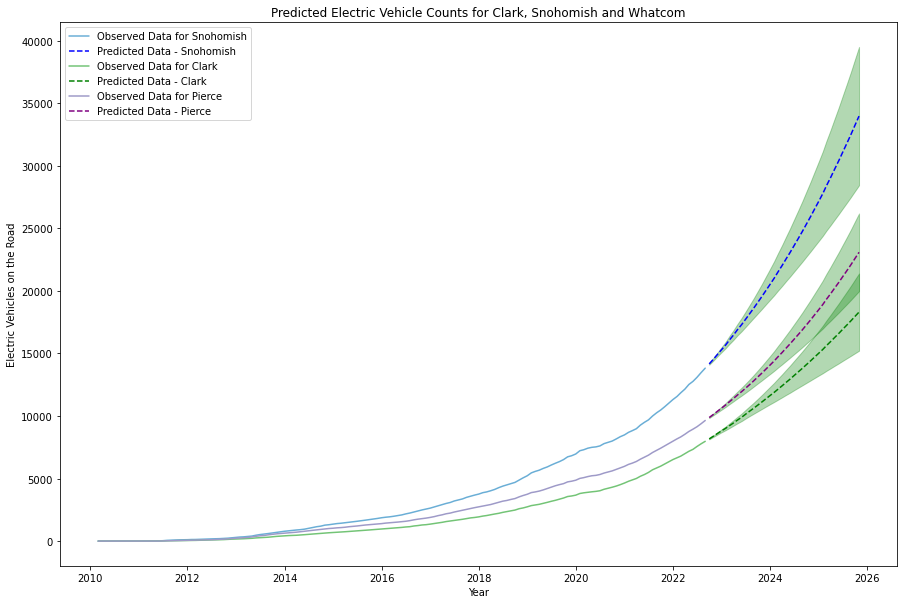

In [163]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicles on the Road')
ax.set_title(f'Predicted Electric Vehicle Counts for Clark, Snohomish and Whatcom')

for county in ['Snohomish','Clark','Pierce']:
    prediction_df = county_information[county]['Predictions']
    
    if county == 'Snohomish':
        palette = 'Blues'
        color='blue'
    elif county == 'Clark':
        palette='Greens'
        color='green'
    elif county == 'Pierce':
        palette='Purples'
        color='purple'
    else:
        palette='Reds'
        color='red'
    with plt.style.context('seaborn-whitegrid'):
                county_df = county_information[county]['df']
                county_df.columns=[f'Observed Data for {county}']
                sns.lineplot(data=county_df, ax=ax, 
                             palette=palette)
                sns.lineplot(data=prediction_df, x=prediction_df.index, 
                             y='Predictions', color=color, ax=ax,  
                             label=f'Predicted Data - {county}', ls='--')
                ax.fill_between(prediction_df.index, 
                                y1=prediction_df['Lower Confidence Interval'], 
                                y2=prediction_df['Upper Confidence Interval'], 
                                alpha=0.3, color='green')
ax.legend(loc=2);

## Monthly Electric Vehicle Count Predictions for Each County

## King County

In [164]:
round(county_information['King']['Predictions'],0)

,Lower Confidence Interval,Upper Confidence Interval,Predictions
2022-09-30,72665.0,73475.0,73070.0
2022-10-31,73754.0,75245.0,74500.0
2022-11-30,74696.0,76914.0,75805.0
2022-12-31,75534.0,78422.0,76978.0
2023-01-31,76488.0,79917.0,78203.0
2023-02-28,77286.0,81181.0,79234.0
2023-03-31,78175.0,82488.0,80331.0
2023-04-30,79544.0,84236.0,81890.0
2023-05-31,80547.0,85590.0,83068.0
2023-06-30,81671.0,87042.0,84356.0


## Snohomish County

In [165]:
round(county_information['Snohomish']['Predictions'],0)

,Lower Confidence Interval,Upper Confidence Interval,Predictions
2022-09-30,14100.0,14227.0,14163.0
2022-10-31,14423.0,14636.0,14530.0
2022-11-30,14757.0,15052.0,14905.0
2022-12-31,15089.0,15485.0,15287.0
2023-01-31,15409.0,15919.0,15664.0
2023-02-28,15743.0,16375.0,16059.0
2023-03-31,16078.0,16843.0,16460.0
2023-04-30,16437.0,17344.0,16891.0
2023-05-31,16763.0,17821.0,17292.0
2023-06-30,17111.0,18330.0,17720.0


## Pierce County


In [166]:
round(county_information['Pierce']['Predictions'],0)

,Lower Confidence Interval,Upper Confidence Interval,Predictions
2022-09-30,9841.0,9917.0,9879.0
2022-10-31,10058.0,10187.0,10122.0
2022-11-30,10273.0,10459.0,10366.0
2022-12-31,10497.0,10744.0,10620.0
2023-01-31,10718.0,11031.0,10875.0
2023-02-28,10935.0,11319.0,11127.0
2023-03-31,11167.0,11628.0,11397.0
2023-04-30,11400.0,11943.0,11671.0
2023-05-31,11625.0,12255.0,11940.0
2023-06-30,11855.0,12577.0,12216.0


## Clark County


In [167]:
round(county_information['Clark']['Predictions'],0)

,Lower Confidence Interval,Upper Confidence Interval,Predictions
2022-09-30,8135.0,8204.0,8169.0
2022-10-31,8323.0,8443.0,8383.0
2022-11-30,8506.0,8679.0,8593.0
2022-12-31,8692.0,8924.0,8808.0
2023-01-31,8862.0,9159.0,9010.0
2023-02-28,9029.0,9395.0,9212.0
2023-03-31,9220.0,9661.0,9440.0
2023-04-30,9411.0,9930.0,9671.0
2023-05-31,9587.0,10190.0,9889.0
2023-06-30,9791.0,10483.0,10137.0


## Thurston County

In [168]:
# round(county_information['Thurston']['Predictions'],0)

## Kitsap County

In [169]:
# round(county_information['Kitsap']['Predictions'],0)

## Whatcom County

In [170]:
# round(county_information['Whatcom']['Predictions'],0)

## Spokane County


In [171]:
# round(county_information['Spokane']['Predictions'],0)

## Benton County

In [172]:
# round(county_information['Benton']['Predictions'],0)

## Skagit County

In [173]:
# round(county_information['Skagit']['Predictions'],0)